Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---
<div style="background-color: #c1f2a5">


# PS10

In this problem set, we are going to implement k-means clustering.
    
# Instructions



Remember to do your problem set in Python 3. Fill in `#YOUR CODE HERE`.

Unless we specify otherwise, make sure: 
- that all plots are scaled in such a way that you can see what is going on (while still respecting specific plotting instructions) 
- that the general patterns are fairly represented.
- to label all x- and y-axes, and to include a title.
    
**Test cases are here to help you debug your code, but passing them successfully is not a guarantee that your code is correct.**
    
</div>

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# import math

An example observation from the categories cat, dog, and mop are presented below:
![](images/test.png)
We assume each observation can be represented as a pair of ($x,y$) coordinates, i.e., each object is represented in two-dimensional space. Suppose we have observed some observations from each type of object, but have lost the information as to which instance belongs to which type!

To try and recover this information we will use an unsupervised learning algorithm called _k-means clustering_. As you may recall from lecture, the $k$ here refers to how many types of clusters we think exist in the data, and the goal of the algorithm is to assign labels to the data points using their distance to the centers (or means) of the clusters. In other words, the data points should be assigned the category label of the cluster whose center is closest to the data point. For this particular problem, we assume $k=3$. After randomly initializing cluster centers,
the algorithm can be broken down into two alternating steps: 

1. Update the label assignments of the data points based on the nearest cluster centers
2. Update the positions of the cluster centers to reflect the updated assignments of data points.

Before you begin, load the data we will be using. For answering the questions in this problem set, use the `centers` loaded from the `X.npz`  file below (i.e., do NOT randomly initialize the values yourself - the autograder for this problem relies on a "stock" initialization).

<div class="alert alert-warning">
**N.B.** we use non-random initializations for the cluster centers to make tests letting you know if your code is correct feasible until Q4. Normally, cluster centers would be randomly initialized, and we will implement this in Q5. 
</div>

In [2]:
data = np.load('data/X.npz')
X = data['X']
centers = data['centers'] 

print ('[x,y] coordinates of observations: \n' + str(X))
print ('\n[x,y] coordinates of cluster centers: \n' + str(centers))

[x,y] coordinates of observations: 
[[3.17014624 2.42738134]
 [3.10945591 1.90239505]
 [2.96418311 1.82748366]
 [2.91461687 1.88794482]
 [3.51445266 2.17859409]
 [2.90636624 1.67106719]
 [2.9524492  2.15678052]
 [2.7653169  1.66717629]
 [2.79663441 1.96728796]
 [2.85409531 1.54327596]
 [3.63398062 2.9905047 ]
 [3.67321618 2.9501688 ]
 [3.32811256 3.22041747]
 [3.57939394 2.98596398]
 [3.54071059 2.78969028]
 [3.78977898 2.96128904]
 [3.53209701 3.29714867]
 [3.75986453 2.89627318]
 [3.47080721 2.83534581]
 [3.33792577 3.24599767]
 [3.02530687 3.60834344]
 [2.90932354 4.26426491]
 [2.81529304 3.85310555]
 [2.6300394  4.0755554 ]
 [3.03834294 4.0548656 ]
 [2.92074563 3.78044972]
 [3.07972956 3.28465006]
 [2.63586335 4.13388882]
 [3.33045863 3.91449067]
 [3.12180098 3.85053529]]

[x,y] coordinates of cluster centers: 
[[4.02596083 2.52095016]
 [3.07295517 3.6180417 ]
 [2.10083931 2.40466689]]


---

## Q1.1 Distance [SOLO, 2pts]

First, we will need a function that gives us the distance between two points. We can use _Euclidean distance_ to compute the distance between two points ($x_1,y_1$) and ($x_2,y_2$). Recall **from the MDS examples** that Euclidean distance in $\mathbb{R}^2$ is calculated as:

$$
distance((x_1,y_1),(x_2,y_2)) = \sqrt{(x_1 - x_2)^{2} + (y_1 - y_2)^{2}}
$$

<div class="alert alert-success">
Complete the `distance` function below to calculate the euclidean distance between two points in $\mathbb{R}^2$. Copy-paste your code in gradescope.
</div>

In [11]:
def distance(a, b):
    """
    Returns the Euclidean distance between two points, 
    a and b, in R^2.
    
    Parameters
    ----------
    a, b : numpy arrays of shape (2,)
        The (x,y) coordinates for two points, a and b, 
        in R^2. E.g., a[0] is the x coordinate, 
        and a[1] is the y coordinate.
            
    Returns
    -------
    distance : float
        The Euclidean distance between a and b
    """
    # YOUR CODE HERE
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

In [15]:
# add your own test cases here!


In [13]:
"""Check distances computes the correct values"""
from numpy.testing import assert_allclose

assert_allclose(distance(np.array([0.0, 0.0]), np.array([0.0, 1.0])), 1.0)
assert_allclose(distance(np.array([3.0, 3.0]), np.array([4.3, 5.0])), 2.3853720883753127)
assert_allclose(distance(np.array([130.0, -25.0]), np.array([0.4, 15.0])), 135.63244449614552)

print("Success!")

Success!


## Q1.2 Assignments [HELP, 3pts]
<div class="alert alert-success">Now, we will write a function to update the cluster that each point is assigned to. To do so, we will compute the distance of a point to the center of each cluster, and figure out which center is the closest one. Complete the `update_assignments` function to do this using your `distances` function. Copy-paste your code in gradescope.

The next cell provides a test case. If it does not return "Success!", your code is incorrect.</div>

In [37]:
def update_assignments(num_clusters, X, centers):
    """
    Returns the cluster assignment (number) for each data point 
    in X, computed as the closest cluster center. Therefore, the 
    output is going to be an array with the length corresponding 
    to the number of datapoints.
    
    Parameters
    ----------
    num_clusters : int
        The number of disjoint clusters (i.e., k) in 
        the X
    
    X : numpy array of shape (m, 2)
        An array of m data points in R^2.
    
    centers : numpy array of shape (num_clusters, 2)
        The coordinates for the centers of each cluster
        
    Returns
    -------
    cluster_assignments : numpy array of shape (m,)
        An array containing the cluster label assignments 
        for each data point in X. Each cluster label is an integer
        between 0 and (num_clusters - 1). 
    """
    # YOUR CODE HERE
    num_points = len(X)
    cluster_assignments = np.zeros(num_points)
    for i in range(num_points):
        lst_distances = [distance(X[i], center) for center in centers]
        cluster_assignments[i] = lst_distances.index(min(lst_distances))
    return cluster_assignments

In [38]:
# add your own test cases here!


In [39]:
"""Check update_assignments computes the correct values"""
from nose.tools import assert_equal
from numpy.testing import assert_array_equal

# load the data
data = np.load('data/X.npz')
X = data['X']

# validate update_assignments using different values
actual = update_assignments(2, X, np.array([[3, 2], [1, 4]]))
expected = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0])

# is the output of the correct shape?
assert_equal(actual.shape[0], X.shape[0])

# are the cluster labels correct?
assert_array_equal(expected, actual)

# validate update_assignments using different values
actual = update_assignments(3, X[:int(X.shape[0]/2)], np.array([X[0], X[1], X[2]]))
expected = np.array([0, 1, 2, 2, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0])

# is the output of the correct shape?
assert_equal(actual.shape[0], X.shape[0] / 2)

# are the cluster labels correct?
assert_array_equal(expected, actual)

# check that it uses distance
old_distance = distance
del distance
try:
    update_assignments(2, X, np.array([[3, 2], [1, 4]]))
except NameError:
    pass
else:
    raise AssertionError("update_assignments does not call distance")
finally:
    distance = old_distance
    del old_distance

print("Success!")

Success!


---
## Q2. Update [HELP, 3pts] 

<div class="alert alert-success">Now, we need to do the next step of the clustering algorithm: recompute the cluster centers based on which points are assigned to that cluster. Recall that the new centers are simply the two-dimensional means of each group of data points in the cluster. A two-dimensional mean is calculated by simply finding the mean of the x coordinates and the mean of the y coordinates. Complete the `update_parameters` function to do this (check out the doc string to make sure you return the right output). Copy your code in gradescope. </div>

In [45]:
def update_parameters(num_clusters, X, cluster_assignment):
    """
    Recalculates cluster centers running update_assignments.
    
    Parameters
    ----------
    num_clusters : int
        The number of disjoint clusters (i.e., k) in 
        the X
    
    X : numpy array of shape (m, 2)
        An array of m data points in R^2
    
    cluster_assignment : numpy array of shape (m,)
        The array of cluster labels assigned to each data 
        point as returned from update_assignments
    
    Returns
    -------
    updated_centers : numpy array of shape (num_clusters, 2)
        An array containing the new positions for each of 
        the cluster centers
    """
    # YOUR CODE HERE
    updated_centers = np.zeros(num_clusters*2).reshape(num_clusters,2)
    for i in range(num_clusters):
        points_idx = [j for j in range(len(cluster_assignment)) if cluster_assignment[j]==i]
        points = [X[k] for k in points_idx]
        updated_centers[i] = np.mean(points, axis=0)
    return updated_centers

In [46]:
# add your own test cases here!


In [47]:
"""Check update_parameters computes the correct values"""
from nose.tools import assert_equal
from numpy.testing import assert_allclose

# load the data
data = np.load('data/X.npz')
X = data['X']

# validate update_assignments using different values
cluster_assignment1 = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0])
actual = update_parameters(2, X, cluster_assignment1)
expected = np.array([[ 3.24286584,  2.71362623], [ 2.80577245,  4.07633606]])
assert_allclose(expected, actual)

cluster_assignment2 = np.array([0, 1, 2, 2, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0])
actual = update_parameters(3, X[:int(X.shape[0]/2)], cluster_assignment2)
expected = np.array([[ 3.4914304 ,  2.79181724], [ 3.03095255,  2.02958778], [ 2.86686881,  1.76070598]])
assert_allclose(expected, actual, rtol=1e-6)
    
print("Success!")

Success!


---
## Q3. Running k-means [3pts, SOLO]

At this stage you are ready to run the $k$-means clustering algorithm! The `k_means` function below will call your functions from Q1.2 and Q2 to run the k-means algorithm on the data points in `X`. Note that for this problem we assume that $k = 3$.

Take a look at the function `k_means` we're providing below, and run the next cell to call it.

In [52]:
def k_means(num_clusters, X, centers, update_assignments, 
            update_parameters, n_iter=4, plotting = True):
    """
    Runs the k-means algorithm for n_iter iterations and plots
    the results.
    
    Parameters
    ----------
    num_clusters : int
        The number of disjoint clusters (i.e., k) to search for
        in X
    
    X : numpy array of shape (m, 2)
        An array of m data points in R^2
        
    centers : numpy array of shape (num_clusters, 2)
        The coordinates for the centers of each cluster
        
    update_assignments : function
        The function you completed in part A
    
    update_parameters : function
        The function you completed in part B
    
    n_iter : int (optional)
        The number of iterations to run the k_means update procedure.
        If not specified, defaults to 4.
    
    plotting : boolean (optional)
        plot the steps if true
        
    Returns
    -------
    cluster_assignments : numpy array of shape (m,) 
        The final label assignments for each of the data points in X
        
    centers : numpy array of shape (num_clusters, 2)
        The final cluster centroids in R^2 after running k-means
        
    fig: the figure object
    """
    if plotting:
        fig, ax = plt.subplots(2, n_iter,figsize=(30,15))
        fig.tight_layout(h_pad=2.0)
        ax = ax.flatten()

    for i in range(n_iter):
        # Step 1: Update cluster assignments
        cluster_assignments = \
            update_assignments(num_clusters, X, centers)
           
        if plotting:
            # plot data with colors corresponding to cluster assignments
            for j in range(X.shape[0]):
                if cluster_assignments[j] == 0:
                    ax[2*i].plot(X[j,0], X[j,1], 'r.')
                elif cluster_assignments[j] == 1:
                    ax[2*i].plot(X[j,0], X[j,1], 'b.')
                else:
                    ax[2*i].plot(X[j,0], X[j,1], 'g.')

            # plot the centers as stars with the associated color
            ax[2*i].plot(centers[0,0], centers[0,1], 'r*', markersize=10)
            ax[2*i].plot(centers[1,0], centers[1,1], 'b*', markersize=10)
            if len(centers)>2:
                ax[2*i].plot(centers[2,0], centers[2,1], 'g*', markersize=10)
            ax[2*i].set_title('Step 1: \nIteration ' + str(i+1))

            ax[2*i].set_xlim([2, 4.5])
            ax[2*i].set_ylim([1, 4.5])
            ax[2*i].set_xticks([]) 
            ax[2*i].set_yticks([])
        
        # Step 2: Update the cluster centers
        centers = \
            update_parameters(num_clusters, X, cluster_assignments)
        
        if plotting:
            # Plot data assignments with the updated center positions
            for j in range(X.shape[0]):
                if cluster_assignments[j] == 0:
                    ax[2*i+1].plot(X[j,0], X[j,1], 'r.')
                elif cluster_assignments[j] == 1:
                    ax[2*i+1].plot(X[j,0], X[j,1], 'b.')
                else:
                    ax[2*i+1].plot(X[j,0], X[j,1], 'g.')

            # Plot cluster centers as stars
            ax[2*i+1].plot(centers[0][0], 
                           centers[0][1], 
                           'r*', markersize=10)
            ax[2*i+1].plot(centers[1][0], 
                           centers[1][1], 
                           'b*', markersize=10)
            
            if len(centers)>2:
                ax[2*i+1].plot(centers[2][0], 
                               centers[2][1], 
                               'g*', markersize=10)
                
            ax[2*i+1].set_title('Step 2: \nIteration ' + str(i+1))

            ax[2*i+1].set_xlim([2, 4.5])
            ax[2*i+1].set_ylim([1, 4.5])
            ax[2*i+1].set_xticks([])
            ax[2*i+1].set_yticks([])
        
    if plotting:
        plt.show()
        return cluster_assignments, centers, fig
    else: 
        return cluster_assignments, centers

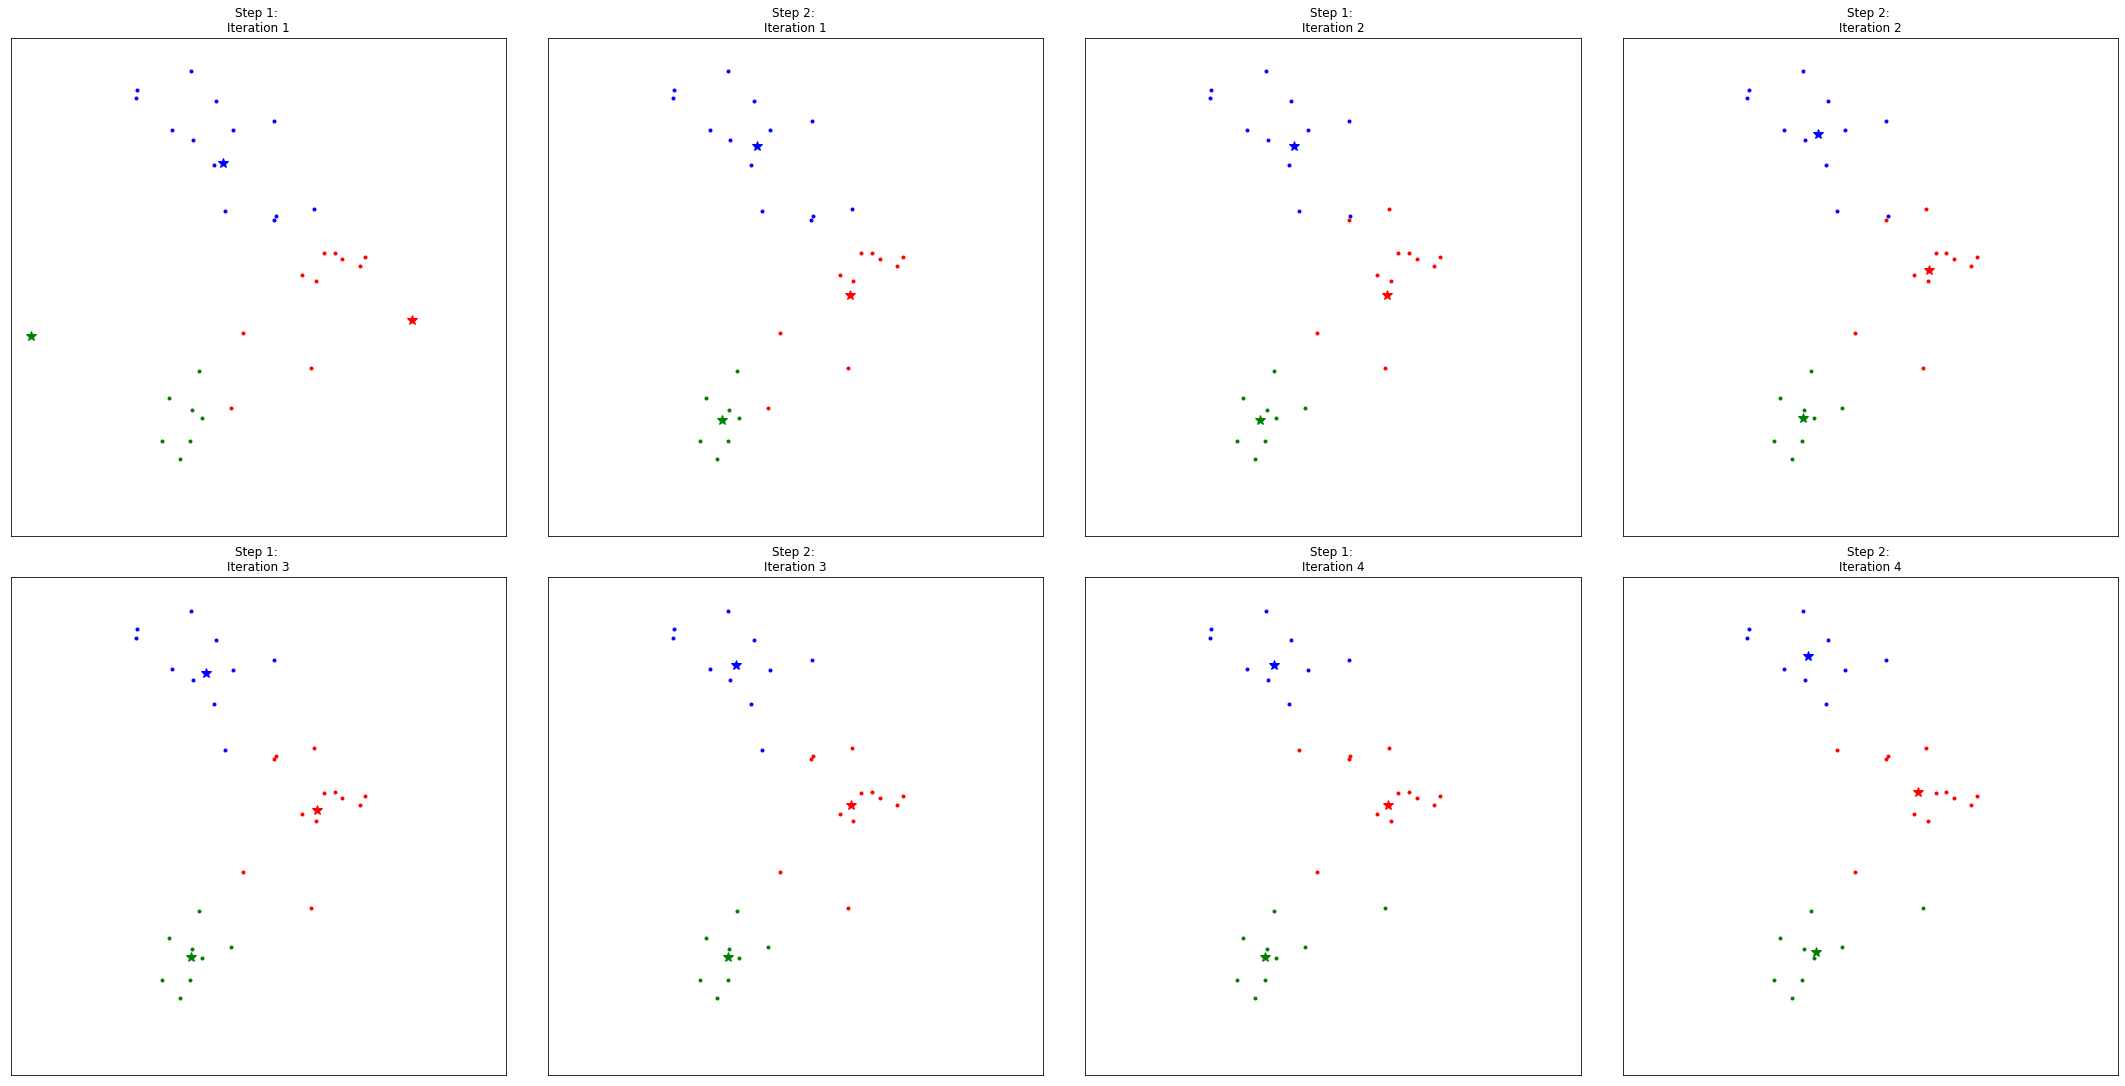

In [53]:
# load the data
data = np.load('data/X.npz')
X = data['X']
centers = data['centers'] 

# run k-means
cluster_assignments, updated_centers, fig = k_means(3, X, centers, update_assignments, update_parameters, n_iter=4)

fig.savefig('PS10_Q3.png')

If the functions you completed above are working properly, you should see a figure containing a subplot of the output from steps (1) and (2) for four iterations of the algorithm. This plot should give you a sense of how the algorithm progresses over time. The data points are each assigned to one of three colors corresponding to their current cluster label. The cluster centers are plotted as stars.

<div class="alert alert-success"> Upload the screenshot of PS10_Q3.png in Gradescope. Describe what happened in the 4 2-step iterations in 2-3 sentences. Do you think we need more iterations in this particular case? Explain why in one sentence, in gradescope. </div>

What happened: 

For each iteration, in step 1, every data point is assigned to one of the three categories (blue, green, red) whose center (either the initial values provided or the result of step 2 from the previous iteration) is the closest to the data point being assigned; and in step 2, the centers of all three categories are updated by taking the two-dimensional means (the mean of all the x coordinates and the mean of all the y coordinates) of all the data points assigned to each category. These two steps are repeated in each of the four iterations; after step 1 in each iteration, the data point assignment is updated so that the data points in each category become more clustered than in the previous iteration; after step 2 in each iteration, the centers of categories are updated to reflect the changes of data point assignment done in step 1 so that now they represent the centers of updated clusters.


More iterations:

Yes, I think we need at least one more iteration in this particular case. 

For example, if we look at the discrete green point and red point in the middle of the space between the red cluster and the green cluster, it is clear that the red point is actually closer to the green cluster than to the red cluster, and this red point is also closer to the green cluster than the green point is -- this point will be categorized into the green category in step 1 the next iteration, which better reflect the structure of these data points; if we do more iterations, boundary cases like this can be categorized more precisely.



## Q4. New object

Now that we have assigned cluster labels to each datapoint, let's investigate how we should classify a _new_ object (which we can see is a Shih-Tzu):

![](images/maddie.png)



Complete the function template in `assign_new_object` to determine the appropriate cluster label for this new object.

In [54]:
def assign_new_object(new_object, updated_centers):
    """
    Returns the cluster label (number) for new_object using k-means 
    clustering.
    
    Parameters
    ----------
    new_object : numpy array of shape (2,)
        The (x,y) coordinates of a new object to be classified
        
    updated_centers : numpy array of shape (num_clusters,2)
        An array containing the updated (x,y) coordinates for 
        each cluster center
        
    Returns
    -------
    label : int
       The cluster label assignment for new_object. This is a
       number between 0 and and (num_clusters - 1).
    """
    # YOUR CODE HERE
    lst_distances = [distance(new_object, updated_center) for updated_center in updated_centers]
    return lst_distances.index(min(lst_distances))

In [55]:
# add your own test cases here!


In [56]:
"""Check assign_new_object computes the correct values"""
from nose.tools import assert_equal

# validate update_assignments using different values
centers1 = np.array([[ 3.17014624,  2.42738134], [ 2.90932354,  4.26426491]])
assert_equal(assign_new_object(np.array([0, 1]), centers1), 0)
assert_equal(assign_new_object(np.array([1, 0]), centers1), 0)
assert_equal(assign_new_object(np.array([3, 2]), centers1), 0)
assert_equal(assign_new_object(np.array([2, 4]), centers1), 1)

centers2 = np.array([[ 3.170146,  2.427381], [ 3.109456,  1.902395], [ 2.964183,  1.827484]])
assert_equal(assign_new_object(np.array([0, 1]), centers2), 2)
assert_equal(assign_new_object(np.array([1, 0]), centers2), 2)
assert_equal(assign_new_object(np.array([3, 2]), centers2), 1)
assert_equal(assign_new_object(np.array([2, 4]), centers2), 0)

# check that it uses distance
old_distance = distance
del distance
try:
    update_assignments(2, X, np.array([[3, 2], [1, 4]]))
except NameError:
    pass
else:
    raise AssertionError("assign_new_object does not call distance")
finally:
    distance = old_distance
    del old_distance

print("Success!")

Success!


Now that we have the function, let's first rerun $k$-means, to make sure we have the correct variables set:

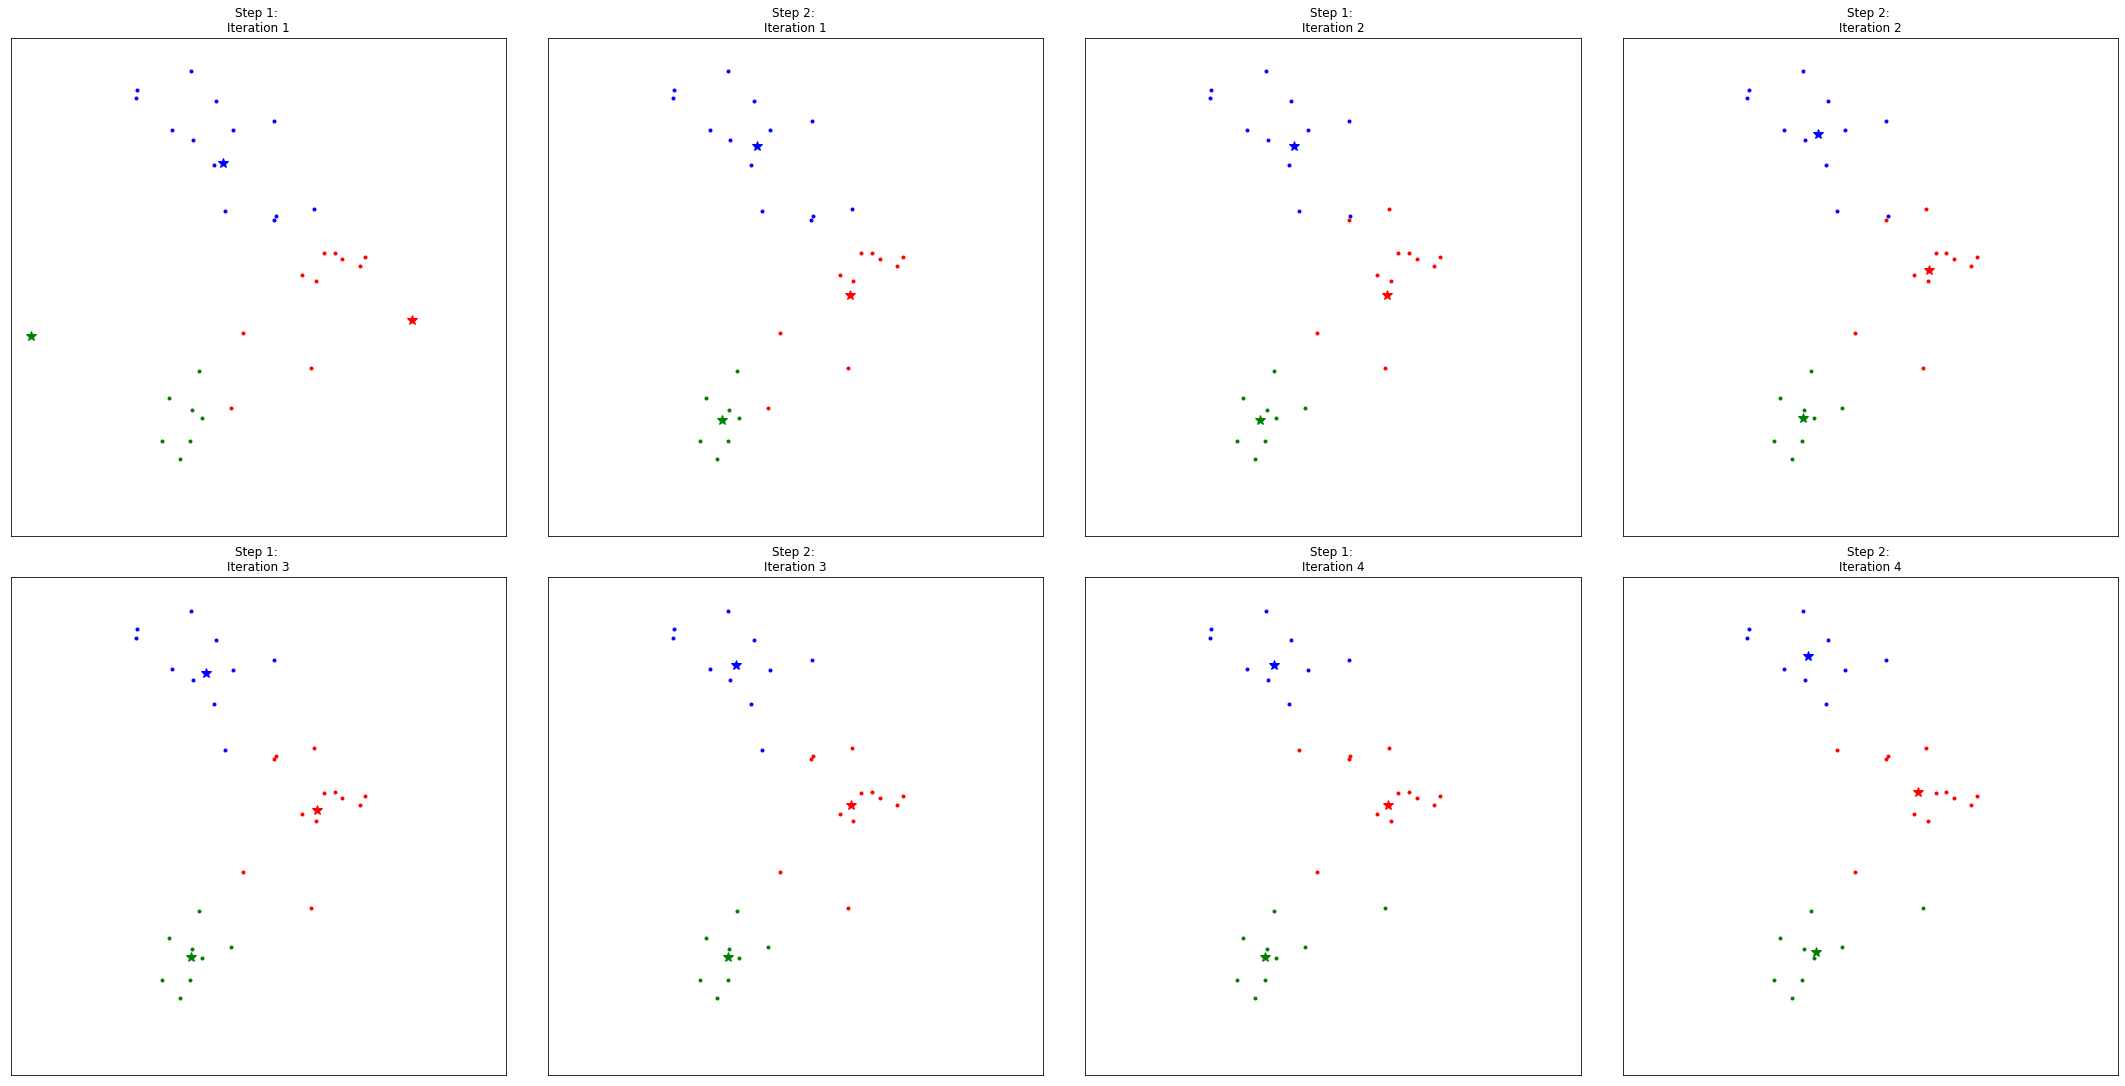

In [57]:
# load the edata
data = np.load('data/X.npz')
X = data['X']
centers = data['centers'] 

# run k-means
cluster_assignments, updated_centers, fig = k_means(3, X, centers, update_assignments, update_parameters, n_iter=4)

Next, let's implement the `assign_new_object` function to classify image of the Shih-Tzu:

In [58]:
new_object = np.array([3.3, 3.5]) # image coordinates
label = assign_new_object(new_object, updated_centers)
print ('The new object was assigned to cluster: '+ str(label))

The new object was assigned to cluster: 0


Finally, we can check the classification result against the true assignments using the provided helper function `plot_final`:

In [59]:
def plot_final(X, cluster_assignments, updated_centers, new_object,
               assign_new_object):
    """
    Categorizes a new object and plots it against the true cluster
    labels.
    
    Parameters
    ----------    
    X : numpy array of shape (m, 2)
        An array of m data points in R^2
    
    cluster_assignments : numpy array of shape (m,) 
        The final label assignments for each of the data points in X
    
    updated_centers : numpy array of shape (num_clusters, 2)
        The coordinates for the centers of each cluster after 
        running k_means
        
    new_object : numpy array of shape (2,)
        The (x,y) coordinates of a new object to be classified
    
    assign_new_object : function
        The function you completed in part D    
        
    Returns
    -------
    label : fig
       The plotted figure.
    """
    fig, ax = plt.subplots(1,2)
    
    # plot data with colors corresponding to cluster assignments
    
    ax[0].plot(X[(cluster_assignments==0),0], X[(cluster_assignments==0),1], 'r.', label='0')
    ax[0].plot(X[(cluster_assignments==1),0], X[(cluster_assignments==1),1], 'b.', label='1')
    ax[0].plot(X[(cluster_assignments==2),0], X[(cluster_assignments==2),1], 'g.', label='2')
    
    # Generate a label for the new object
    label = assign_new_object(new_object, updated_centers)
    
    # Plot the new object as as big circle on the plot
    if label == 0:
        ax[0].plot(new_object[0], new_object[1], 'ro', markersize=10)
    elif label == 1:
        ax[0].plot(new_object[0], new_object[1], 'bo', markersize=10)
    else:
        ax[0].plot(new_object[0], new_object[1], 'go', markersize=10)
    
    ax[0].set_aspect('equal', 'datalim')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Final Cluster Assignments')
    ax[0].legend()
    
    # Plot the true cluster assignments for comparison
    ax[1].plot(X[:10, 0], X[:10, 1], 'r.', label='cats')
    ax[1].plot(X[10:20,0], X[10:20, 1], 'b.', label='dogs')
    ax[1].plot(X[20:, 0], X[20:, 1], 'g.', label='mops')
    ax[1].set_title('True Cluster Assignments')
    ax[1].set_aspect('equal', 'datalim')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].legend()
    plt.show()
    
    return fig


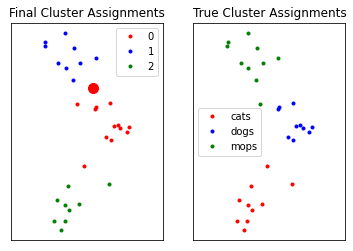

In [60]:
fig = plot_final(X, cluster_assignments, updated_centers, new_object, assign_new_object)

fig.savefig('PS10_Q4.png')


## Q4.1. New object [HELP, 2pts].

<div class="alert alert-success">
 When interpreting these plots, don't worry if the coloring differs between the two solutions; what matters is whether $k$-means identifies the same cluster boundaries as are shown in the true clusters. In gradescope, explain in one sentence why the coloring scheme does not matter - [hint: what do the cluster labels mean in the algorithm?]
    


The coloring scheme is based on the sequence of cluster labels, and the cluster labels in our algorithm merely mean the index of the cluster center coordinates in the list of coordinates for all the centers; initial cluster center coordinates can be randomly shifted and/or generated and thus do not have a fixed correspondence to any real categorical meaning.



## Q4.2. New object [SOLO, 5pts].

<div class="alert alert-success">
    
A. Did the algorithm correctly identify the Shih-Tzu?  Give an Yes/No answer, and a one sentence explanation for how you reached this conclusion.
    
B. Do you notice any differences between the true clusters and those identified via $k$-means? Write a few sentences commenting on any differences you found and why these differences might exist. Hint: are some dots that are originally in one cluster incorrectly identified as a part of a different cluster? Why might that be the case?
    
Upload your figure PS10_Q4.png in gradescope.</div>

A. Yes, the algorithm correctly identifies the Shih-Tzu as a dog. The data points in the true "dogs" cluster are all in the "0" cluster in our "First Cluster Assignments" plot, and there are very few (2 boundary cases only) data points in the "0" cluster that does not belong to the true "dogs" cluster; therefore, we can infer that the "0" cluster which the Shih-Tzu (a kind of dog) is in is the "dogs" cluster.


B. There are two differences:

(1) A data point (bottom left one in the "0" cluster in our "First Cluster Assignments" plot) belongs to the "cats" cluster ("2" cluster in our "First Cluster Assignments" plot) is incorrectly identified as being in the "dogs" cluster ("0" cluster in our "First Cluster Assignments" plot). The reason why this is the case has already been partly discussed in Q3. Since the initial center for the "2" cluster is on the far left side of the plot (very far away from the potential cluster), it takes relatively more iterations to move it to the appropriate position; and because we have only done 4 iterations, this data point has not had a chance to be included in the "2" cluster yet. But if we do one more iteration, this data point will be assigned correctly to the "2" cluster, because it is clear from the plot of step 2 iteration 4 that this data point is actually already closer to the newly updated "2" cluster center than to the "0" cluster center.

(2) A data point (top left one in the "0" cluster in our "First Cluster Assignments" plot) belongs to the "mops" cluster ("1" cluster in our "First Cluster Assignments" plot) is incorrectly identified as being in the "dogs" cluster ("0" cluster in our "First Cluster Assignments" plot). This is probably related to the issue mentioned in (1). Since the data point mentioned in (1) is incorrectly assigned to "0" cluster, the center of "0" cluster is shifted to the left side due to this relatively extreme outlier, causing the data point we are now discussing in (2) to be closer to the "0" cluster center instead of the "1" cluster center. This incorrect assignment is expected to be corrected once we have done more iterations to let the data point mentioned (1) to be correctly assigned to the "2" cluster (instead of the "0" cluster) and the center of the "0" cluster shifts to the right a little bit.


## Q5. Random starting points [HELP, 5pts].

<div class="alert alert-success">
We are providing a function `init_centers` which will return random starting points for the center of each cluster. Take a look at the function below.  Re-run k-means as you did in Q3, but use init_centers to initialize the random starting points for the centers. Use 6 iterations, rather than 4, to run k-means clustering. Try  running it out multiple times, until your final cluster result is different from the one we obtained in Q3. Save and upload this figure in gradescope as PS10_Q5.png. Explain in 2-3 sentences how this solution differs from the original one. What happened in the algorithm to produce such results? </div>
    


In [61]:

def init_centers(k=3):
    """
    Randomly initialize cluster centers
    """
    return np.vstack([np.random.uniform(low=2., high=4.5, size=k),
                      np.random.uniform(low=1, high=4.5, size=k)]).T

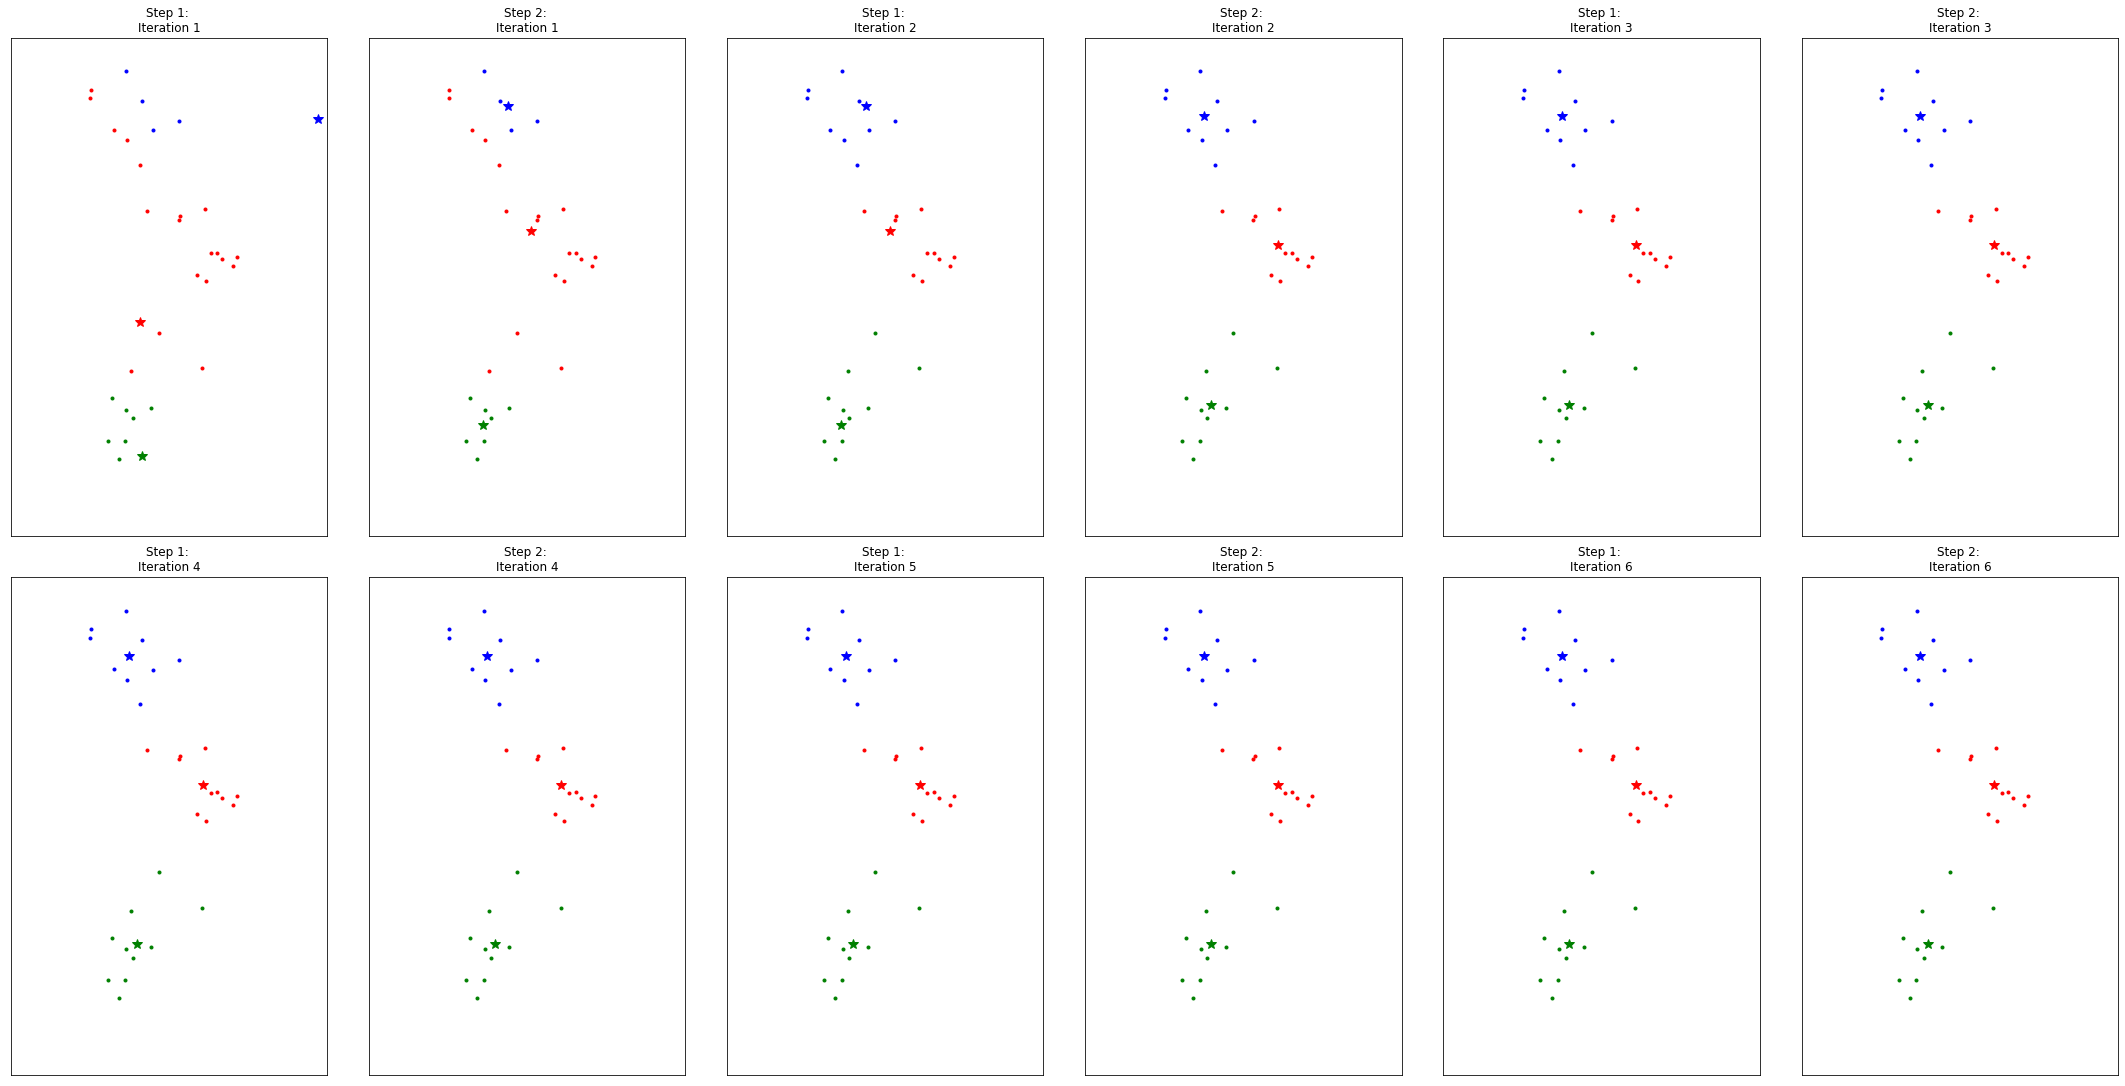

In [105]:
# YOUR CODE HERE
cluster_assignments, updated_centers, fig = k_means(3, X, init_centers(3), update_assignments, update_parameters, 6)

fig. savefig('PS10_Q5.png')

How this solution differs from the original one:

This solution ends up giving only two clusters despite the fact that we initialized three centers. The green center disappears after only one iteration and never appear again; the remaining interactions are just like assigning the data points to two clusters.


How such results are produced:

This is because the randomly generated green center is far at the bottom right corner of the plot while the randomly generated red and blue centers are relatively more to the center of the plot (where the data points lie). This results in all data points being closer to either the red or blue centers than to the green center, leading to no data point being assigned to the green cluster after step 1 iteration 1. Consequently, when updating the coordinates of the centers, since there is no data for the green center, its updated coordinates cannot be calculated by taking the average over all coordinates in the cluster, and thus the green center continues to be absent and the plots end up having only two clusters.


## Q6. Numbers of clusters.

**So far, we have seen examples where we know that there are 3 categories/labels in the data. However, in general you won't know how many clusters there are in the data ahead of time. In this case, you need to figure out the correct/optimal number of clusters (k). Let's try to figure out a way to decide k.**

### Q6.1 k=2. [HELP, 2pts]

<div class="alert alert-success">
Run k-means with k=2, and 4 iterations. Use the cluster center starting points provided by the data (first two of the three). Plot final clusters and upload the figure as PS10_Q6_1.png to Gradescope. Explain the patterns you observe - how does clustering compare to previous results?
</div>
    

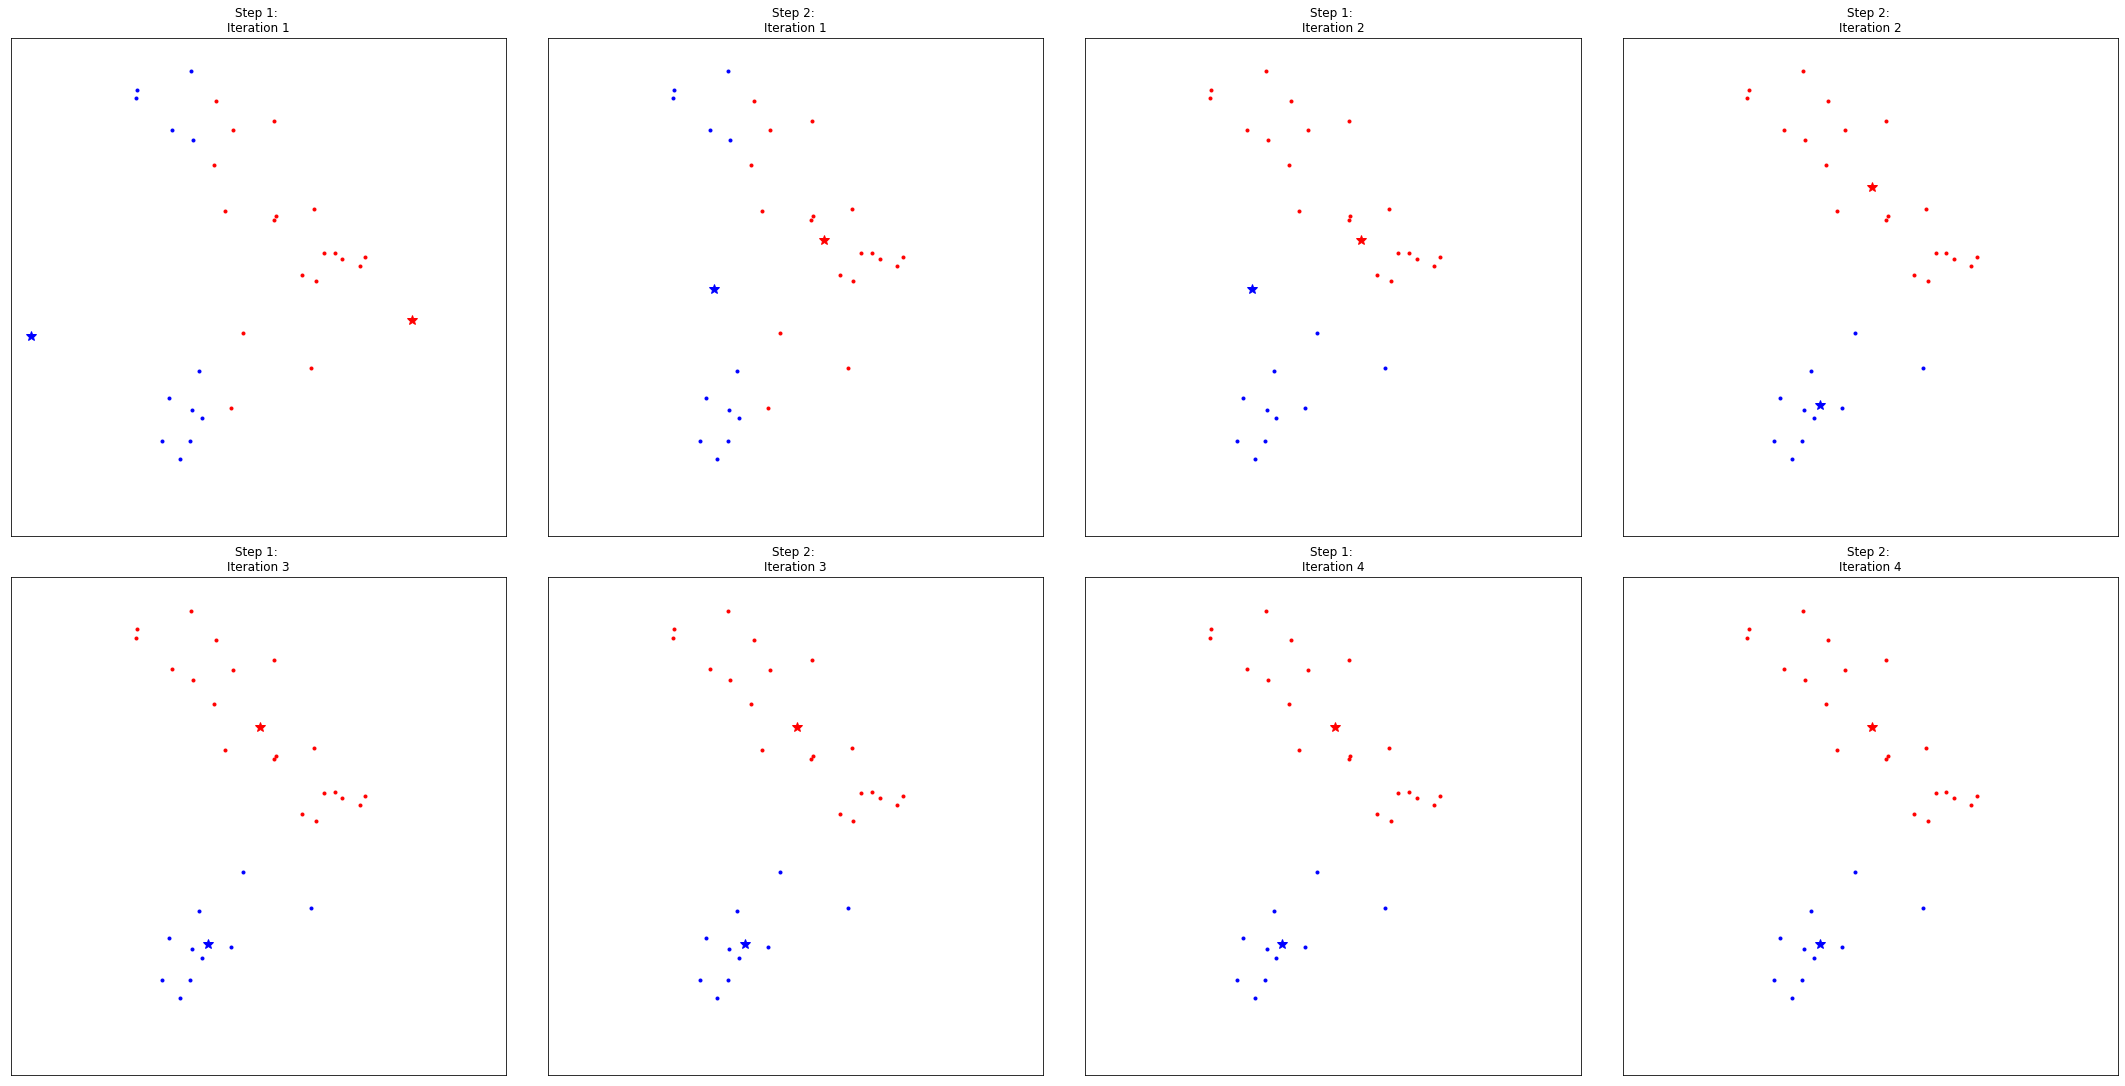

In [76]:
# load the data
data = np.load('data/X.npz')
X = data['X']
centers = data['centers'][(0,2),:] 

# YOUR CODE HERE
cluster_assignments, updated_centers, fig = k_means(2, X, centers, update_assignments, update_parameters, 4)

fig.savefig('PS10_Q6_1.png')

There are only two clusters now instead of three as we were getting before as well as in the true clustering -- mops and dogs are grouped into the same cluster, while cats still form a distinct cluster.

### Q6.2 Average distance. [SOLO, 3pts]

<div class="alert alert-success">
Write a function that computes the average distance a data point to the center of its cluster. We'll try use this measure to see how well the algorithm is doing. Enter in gradescope the average distance for the output of k-means with 4 iterations and the starting point centers provided above. Specifically, copy-paste the printed output of the cell (this will be auto-graded).</div>
    

In [86]:

def average_distance(X,centers,cluster_assignments):
    """
    returns the average distance to clusters
    
    Parameters
    ----------    
    X : numpy array of shape (m, 2)
        An array of m data points in R^2
    
    cluster_assignments : numpy array of shape (m,) 
        The final label assignments for each of the data points in X
    
    centers : numpy array of shape (num_clusters, 2)
        The coordinates for the centers of each cluster after 
        running k_means 
        
    Returns
    -------
    label : 
       The average distance.
    """
    #YOUR CODE HERE
    distances = np.zeros(len(X))
    for i in range(len(X)):
        distances[i] = distance(X[i], centers[int(cluster_assignments[i])])
    return np.mean(distances)

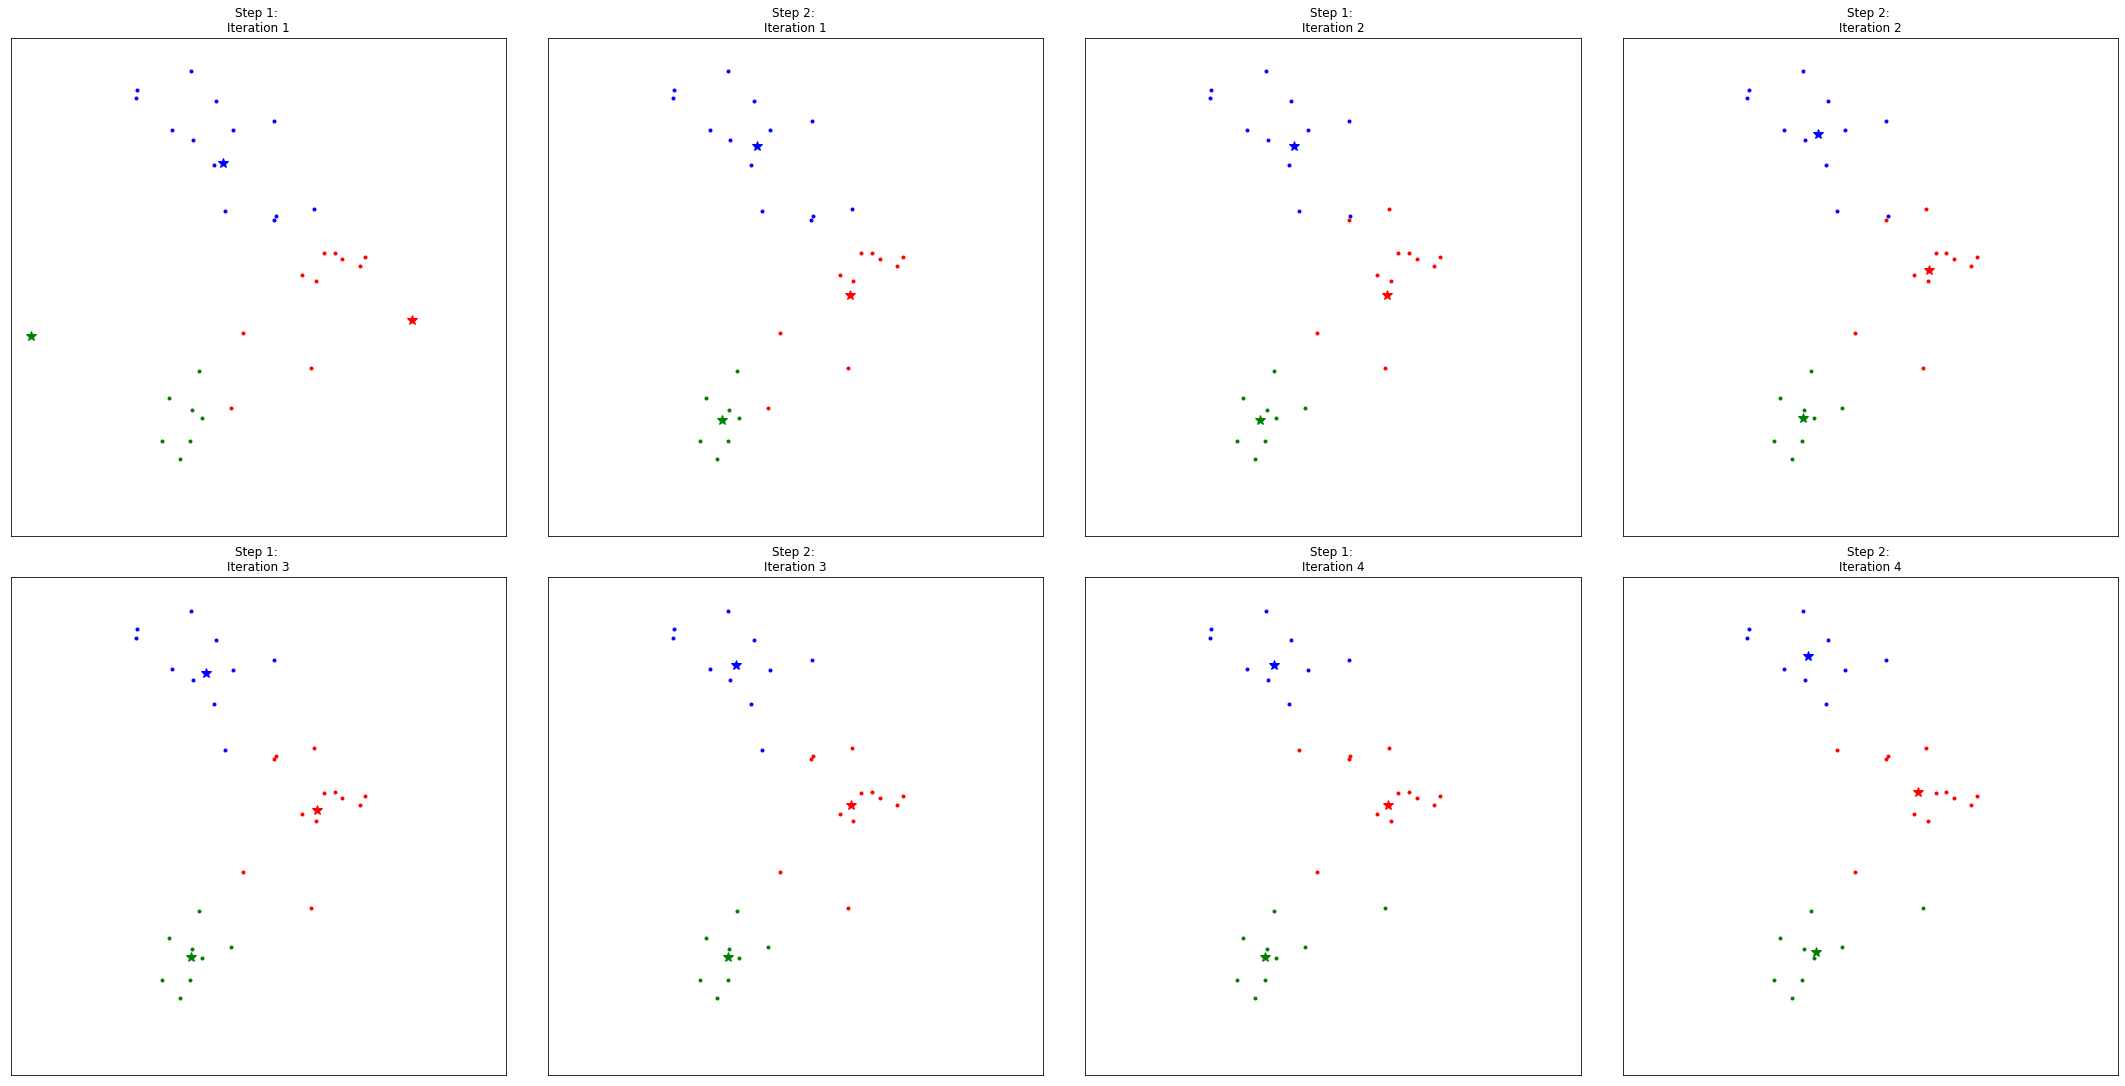

Final distance is: 0.27


In [106]:
# load the data
data = np.load('data/X.npz')
X = data['X']
centers = data['centers'] 

# run k-means
cluster_assignments, updated_centers, fig = k_means(3, X, centers, update_assignments, update_parameters, n_iter=4)

# compute the final distance
print("Final distance is: " + str(np.around(average_distance(X,updated_centers,cluster_assignments),decimals=2)))


### Q6.3 Number of clusters. [SOLO, 5pts]

<div class="alert alert-success">
Compute the average distance for k = 2 through 6, always using 10 iterations of the algorithm. For each value of k, compute the average distance for 20 different random starting point  initialized using init_centers function, and report the minimum over the starting points for this value of k. You should end up with a list or arrya of 5 minimum average distance values, one for each value of k. Create a bar plot, showing this minimum average distance as a function of k (x axis = k, y axis = minimum distance). Make sure to set up `plotting=False` as an argument in k-means, so you don't always plot the clustering results for each 20*6 times you run it! Upload your result as PS10_Q6_3.png in gradescope.</div>

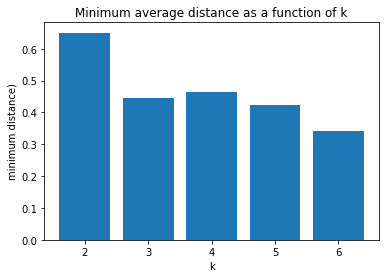

In [109]:
ks = np.arange(2,7)
nsims = 20

#YOUR CODE HERE

average_distances = np.zeros(5)
for k in ks:
    d = []
    for _ in range(20):
        centers = init_centers(k)
        cluster_assignments, updated_centers = k_means(k, X, centers, update_assignments, update_parameters, n_iter=10, plotting=False)
        d.append(average_distance(X, centers, cluster_assignments))
    average_distances[k-2] = min(d)


figure, axis = plt.subplots()
axis.bar(ks, average_distances)
axis.set_xlabel("k")
axis.set_ylabel("minimum distance)")
axis.set_title("Minimum average distance as a function of k")

figure.savefig('PS10_Q6_3.png')

### Q6.4 Evaluating k-means. [HELP, 3]

If you got Q6.3 right, you should see that our average distance measure identifies $k=6$ as better than $k=3$. However, we know that's not the case: there are three clusters in our data. Therefore, our way of trying to determine the optimal number of clusters is flawed. In 2-3 sentences, explain why the measure we chose is not a good measure to determine which value of $k$ we should select. Hint: consider what would happen if we selected $k=$ the number of points in our data set. 

This is not a good measure for determining which value of k to use because, in a general sense, this measure tends to encourage overfitting / having as many clusters as possible since that usually lowers the average distance -- if we have the same number of clusters as the number of points in the data set, we will get an average distance of zero since now the center of every cluster is just the data point itself, and there is no distance between each data point and its cluster center. But this overfitting solution is obviously not a good solution for clustering problems since this is overly complex and does not provide any information regarding category at all -- and category information is exactly what we initially doing clustering for. The optimal number of clusters should be a tradeoff between average distance and simplicity of the solution, rather than only considering the average distance.

---
<div style="background-color: #c1f2a5">

# Submission

When you're done with your problem set, do the following:
- Upload your answers in Gradescope's PS5.

- Convert your Jupyter Notebook into a `.py` file by doing so:    
    
</div>


<center>    
  <img src="https://www.dropbox.com/s/7s189m4dsvu5j65/instruction.png?dl=1" width="300"/>
</center>

<div style="background-color: #c1f2a5">
    
- Submit the `.py` file you just created in Gradescope's PS5-code.
    
</div>        




</div>

</div>
